This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License, version 2, as published by the Free Software Foundation.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

Author: Alexander Young

### This script uses present-day OLIP polygons to calculate OLIP height, area and volume following Schubert & Sandwell, (1989). Then uses the Doucet et al., (2020) plume time series model to estimate time dependent OLIP volumes.

##### Input:
reconstructed coastlines e.g. reconstructed_0.00Ma.xy

reconstructed subduction zone topologies e.g. topology_subduction_boundaries_0.00Ma.xy

global sediment thickness grid GlobSed-v2_resample1deg-x-1deg.nc

##### Output:
present-day OLIP volumes file e.g. Volumes_of_submarine_LIPs.csv

present-day OLIP volumes on CDF plot

time-dependent model of OLIP volume e.g. Model_volumes_of_submarine_LIPs.csv

##### Citations:

Bryan, S. E., and Ernst, R. E., 2008, Revised definition of large igneous provinces (LIPs): Earth-Science Reviews, v. 86, no. 1-4, p. 175-202.

Doucet, L. S., Li, Z.-X., Ernst, R. E., Kirscher, U., El Dien, H. G., and Mitchell, R. N., 2020, Coupled supercontinent–mantle plume events evidenced by oceanic plume record: Geology, v. 48, no. 2, p. 159-163.

Johansson, L., Zahirovic, S., and Müller, R. D., 2018, The Interplay Between the Eruption and Weathering of Large Igneous Provinces and the Deep‐Time Carbon Cycle: Geophysical Research Letters, v. 45, no. 11, p. 5380-5389.

Schubert, G., and Sandwell, D., 1989, submarine plateaus: Earth and Planetary Science Letters, v. 92, p. 234-246.

Whittaker, J., Afonso, J., Masterton, S., Müller, R., Wessel, P., Williams, S., and Seton, M., 2015, Long-term interaction between mid-ocean ridges and mantle plumes: Nature Geoscience, v. 8, no. 6, p. 479-483.

In [3]:
import sys
import os
import os.path
import subprocess
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from numpy import log
from scipy import stats as scistats

# allow plots to appear within the notebook
% matplotlib inline

In [4]:
# implement method of Schubert and Sandwell (1989) to calculate volume of OLIPs
# set working directory and make if it does not exist
workDir="/Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/OLIPModeling"
if not os.path.exists(workDir):
    os.makedirs(workDir)

# -- path OLIPs list - databases of Whittaker et al. (2015) and Johansson et al. (2018)
OLIPsFile ='./DependentInputs/lips_list.dat'

# make empty area, min and max depth lists
areaList = []
mindepthList = []
maxdepthList = []
heightList = []
volumeList = []

# -- read time file
f = open(OLIPsFile)
OLIPsList = []

for line in f:
    parts = line.split() # split line into parts
    OLIPsList.append(parts[0])
        
# -- create time file loop
for i in range(len(OLIPsList)):
    olip = OLIPsList[i]
    
    # Create output folder
    newpath = workDir+'/%s' %(olip)
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    
    # set infiles
    ply_root = './DependentInputs/OLIP_polygons'
    lipsfile = ply_root+"/%s.xy" %(olip) # databases of Whittaker et al. (2015) and Johansson et al. (2018)
    depth2basegrd="./DependentInputs/depth2basement_meters.nc"
    
    # set outfiles
    lipsgrd=newpath+"/depthmin_mask_lip_%s.nc" %(olip)
    lipspolygrd=newpath+"/depthmax_mask_lippoly_%s.nc" %(olip)
    lipfiltergrd=newpath+"/mask_lipfilter_%s.nc" %(olip)
    lipheightgrd=newpath+"/%s-lipheight.nc" %(olip)

    # BEGIN WORKFLOW # 
    # create a grid mask using the lip polygon
    cmd="grdmask %s -A -Rg -I0.1 -NNaN/1/1 -V -Gtmp.grd" %(lipsfile)
    print cmd
    os.system(cmd)
    
    # extract depth to basement value within mask
    cmd="grdmath %s tmp.grd OR = %s" %(depth2basegrd, lipsgrd)
    print cmd
    os.system(cmd)
    
    # convert mask to xyz
    cmd="grd2xyz %s -S -V -Rg > tmp.xyz" %(lipsgrd)
    print cmd
    os.system(cmd)
    
    # find min depth
    min_df = pd.read_csv("./tmp.xyz", delim_whitespace=True, skiprows=0, names=['y', 'x', 'z'])
    mindepthList.append(min_df['z'].mode().iat[0])
    
    # calculate area of lip if its areal extent is > 0.1 Mkm2 (Bryan and Ernst, 2008).
    cmd="gmt spatial -Qe+p+c100000000000+sd -V %s -fg -F -V > aaa" %(lipsfile)
    print cmd
    os.system(cmd)
    aaa = pd.read_csv("./aaa", delim_whitespace=True, skiprows=0, names=['y', 'x', 'area'])
    areaList.append(aaa['area'].iloc[0])
    
    # create a minimum depth grid mask using the lip polygon + 300km
    cmd="grdmask %s -Rg -I0.1 -m -NNaN/1/1 -S300k -Gtmp.grd" %(lipsfile)
    print cmd
    os.system(cmd)
    
    # extract depth to basement value within maximum depth mask
    cmd="grdmath %s tmp.grd OR = %s" %(depth2basegrd, lipsgrd)
    print cmd
    os.system(cmd)
    
    # convert mask to xyz
    cmd="grd2xyz %s -S -V -Rg > tmp.xyz" %(lipsgrd)
    print cmd
    os.system(cmd)
        
    # find max depth
    max_df = pd.read_csv("./tmp.xyz", delim_whitespace=True, skiprows=0, names=['y', 'x', 'z'])
    maxdepthList.append(max_df['z'].mode().iat[0])

    # calculate olip height and volume
    height = (max_df['z'].mode().iat[0] - min_df['z'].mode().iat[0]) * -1.
    heightList.append(height)
    volume = height * aaa['area'].iloc[0]
    volumeList.append(volume)
    
OLIPvolumes = pd.DataFrame({'OLIP':OLIPsList, 'area[m^2]':areaList,
                            "min_depth[m]":mindepthList, "max_depth[m]":maxdepthList,
                            "height[m]":heightList, "volume[m^3]":volumeList,})

OLIPvolumes.to_csv(workDir+"/Volumes_of_submarine_LIPs.csv" )

# tidy up
cmd = "rm tmp.xyz gmt.history tmp.grd aaa"
print cmd
os.system(cmd)


In [5]:
# some olip ploygons cover COB and therefore have false values, here we remove those lips
OLIPvolumes = pd.read_csv(workDir+'/Volumes_of_submarine_LIPs.csv')
OLIPvolumes_clean = OLIPvolumes[OLIPvolumes['volume[m^3]'] > 0.]

# print out OLIP summary stats
OLIPvolumes_clean.describe(percentiles = [.10, .90] )

,Unnamed: 0,area[m^2],height[m],max_depth[m],min_depth[m],volume[m^3]
count,39.00000,3.900000e+01,39.000000,39.000000,39.000000,3.900000e+01
mean,22.25641,2.857404e+11,1224.943722,-5258.117250,-4033.173528,3.120277e+14
std,14.03139,2.998836e+11,770.487079,1019.396639,1107.665760,2.393276e+14
min,0.00000,1.030417e+11,27.906250,-7997.169434,-6528.435547,2.941147e+12
10%,3.80000,1.123295e+11,272.503906,-6247.400000,-5157.553711,4.481209e+13
50%,21.00000,2.100414e+11,1359.799805,-5107.383789,-4153.000000,2.306967e+14
90%,43.20000,4.457353e+11,2165.425781,-4450.307031,-3007.400000,6.514719e+14
max,47.00000,1.879494e+12,2901.854980,-1428.000000,-90.000000,8.281251e+14


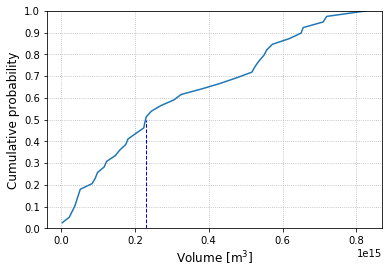

,value,frequency,pdf,cdf
count,3.800000e+01,38.000000,38.000000,38.000000
mean,3.190080e+14,1.026316,0.026316,0.522942
std,2.384830e+14,0.162221,0.004160,0.289269
min,2.941147e+12,1.000000,0.025641,0.025641
10%,4.382962e+13,1.000000,0.025641,0.138462
50%,2.375598e+14,1.000000,0.025641,0.525641
90%,6.520554e+14,1.000000,0.025641,0.905128
max,8.281251e+14,2.000000,0.051282,1.000000


In [6]:
# plot OLIP volumes on CDF plot
# Define series
s = pd.Series(np.sort(OLIPvolumes_clean['volume[m^3]']), name = 'value')
df = pd.DataFrame(s)

# Get the frequency, PDF and CDF for each value in the series
# Frequency
stats_df = df \
.groupby('value') \
['value'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'value': 'frequency'})

# PDF
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

# CDF
stats_df['cdf'] = stats_df['pdf'].cumsum()
stats_df = stats_df.reset_index()
# print stats_df

# Plot the discrete Probability Mass Function and CDF.
fig, ax1 = plt.subplots(figsize=(6,4))

ax1.plot(stats_df['value'], stats_df['cdf'],  label = "CDF")
ax1.set_xlabel('Volume [m$^3$]', fontsize = 12)
ax1.set_ylabel('Cumulative probability', fontsize = 12)

ax1.set_yticks(np.arange(0.,1.1,0.1))
# ax1.axvline(4.481209e+13, 0, 0.1, linestyle='--', linewidth=1., color='blue', zorder=0)
ax1.axvline(2.306967e+14, 0, 0.5, linestyle='--', linewidth=1., color='blue', zorder=0)
# ax1.axvline(6.514719e+14, 0, 0.9, linestyle='--', linewidth=1., color='blue', zorder=0)

plt.ylim(0, 1)
plt.grid(linestyle=':')
plt.savefig(workDir+'/presentday_O-LIP_volCDF.pdf', format='pdf', dpi=600 , bbox_inches = 'tight')
plt.show()
stats_df.describe(percentiles = [.10, .90] )


In [7]:
# Load in Doucet-et-al-2019 OLIPs timedependent count
Doucet = pd.read_csv("./DependentInputs/Doucet-et-al-2019-Geology-OLIPs_count.csv", skiprows=1, names=['Age', 'count', '120Ma_RunningCount', 
                                                                                                      'WorldUncerainty', 'Min', 'Max'])
# Doucet

# model olip volumes
Doucet['mean'] = Doucet['120Ma_RunningCount'] * 3.190080e+14
Doucet['Min'] = Doucet['Min'] * 3.190080e+14
Doucet['Mid'] = Doucet['120Ma_RunningCount'] * 2.375598e+14
Doucet['Max'] = Doucet['Max'] * 3.190080e+14

# export time-ependent OLIP volume model to csv
Doucet.to_csv(workDir+"/Model_volumes_of_submarine_LIPs.csv" )

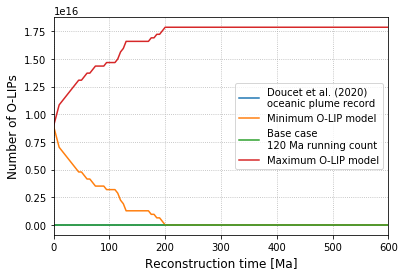

In [8]:
fig = plt.figure(figsize=(6,4))

plt.plot(Doucet['Age'], Doucet['count'], label='Doucet et al. (2020) \noceanic plume record')
plt.plot(Doucet['Age'], Doucet['Min'], label='Minimum O-LIP model')
plt.plot(Doucet['Age'], Doucet['120Ma_RunningCount'], label='Base case \n120 Ma running count')
plt.plot(Doucet['Age'], Doucet['Max'], label='Maximum O-LIP model')
# plt.plot(Doucet['Age'], Doucet['90'], label='p90')
# plt.plot(Doucet['Age'], Doucet['10'], label='p10')

plt.legend()
# plt.ylabel('Volume [m$^3$]', fontsize = 12)
plt.ylabel('Number of O-LIPs', fontsize = 12)
plt.xlabel('Reconstruction time [Ma]', fontsize = 12)
plt.grid(linestyle=':')
plt.xlim(0, 600)
plt.savefig(workDir+'/reconstructed_O-LIP_vols.pdf', format='pdf', dpi=600 , bbox_inches = 'tight')


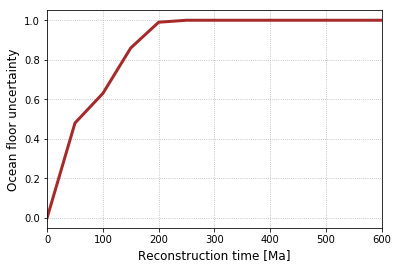

In [9]:
fig = plt.figure(figsize=(6,4))
n=10

plt.plot(Doucet['Age'][::n], Doucet['WorldUncerainty'][::n], color='brown', linewidth=3)
# plt.plot(Doucet['Age'], Doucet['90'], label='p90')
# plt.plot(Doucet['Age'], Doucet['10'], label='p10')

# plt.legend()
# plt.ylabel('Volume [m$^3$]', fontsize = 12)
plt.ylabel('Ocean floor uncertainty', fontsize = 12)
plt.xlabel('Reconstruction time [Ma]', fontsize = 12)
plt.grid(linestyle=':')
plt.xlim(0, 600)
plt.savefig(workDir+'/WorldUncerainty.pdf', format='pdf', dpi=600 , bbox_inches = 'tight')
